## Medical Image Segmentation with YOLOv8
Medical image segmentation is a crucial process in many medical imaging applications.

It involves dividing or partitioning an image into multiple segments or “**regions of interest**” that correspond to different objects or parts of objects.

It processes visual data at the pixel level, using various techniques to annotate individual pixels as belonging to a specific class or instance

In the context of medical imaging, these could be various tissues, organs, cells, or anomalies like tumors.


### Importance of Medical Image Segmentation
Medical image segmentation plays a vital role in numerous biomedical applications, including:

1. **Disease Diagnosis and Monitoring**: It helps in the identification and visualization of anomalies or structures of interest in medical images, aiding in disease diagnosis and monitoring.
2. **Treatment Planning**: It provides critical information for planning treatment strategies, such as radiation therapy for cancer treatment.
3. **Computer-Aided Surgery**: It assists in pre-operative planning and
intra-operative navigation during surgical procedures.

### Applications of Medical Image Segmentation
1. **Tumor Detection**: It can help in the detection and localization of tumors in various parts of the body.
2. **Organ Delineation**: It can assist in delineating organs in medical images, which is crucial for surgical planning and organ transplantation.
3. **Blood Vessel Visualization**: It can aid in visualizing blood vessels in angiography images, which is essential for diagnosing and treating vascular diseases.
4. **Cell Counting and Classification**: It can help in counting and classifying cells in microscopic images, which is crucial in diagnosing diseases like cancer and monitoring treatment response.
5. **Fracture Identification**: It can assist in identifying and analyzing fractures, which is vital for treatment planning and monitoring the recovery process.

### YOLOv8 for Medical Image Segmentation
YOLOv8 (You Only Look Once version 8) is a state-of-the-art, real-time object detection system that can also be used for medical image segmentation. It can classify, detect, and segment objects in images, making it a versatile tool for medical image analysis.

Due to its high quality and real-time performance, YOLOv8 is highly effective when it comes to segmentation.


**Let's get started!**

In [1]:
#install packages
!pip install ultralytics
!pip install -U ipywidgets

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


## Loading the image data

In [1]:
import os
import random
import torch
import pandas as pd
import zipfile
import urllib.request
from ultralytics import YOLO
import matplotlib.pyplot as plt


url = "https://app.roboflow.com/ds/eHJfgHtWU6?key=oqtIXB35p3"

#"https://universe.roboflow.com/ds/q0qpMlkLs9?key=tHF5THkddW"

urllib.request.urlretrieve(url, "seg2.zip")

print("File downloaded successfully!")


File downloaded successfully!


In [2]:
#create a directory to save contents of the zip file
!mkdir seg2
!unzip seg2.zip -d data/

mkdir: cannot create directory ‘seg2’: File exists
Archive:  seg2.zip
replace data/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: data/README.dataset.txt  
replace data/README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: data/README.roboflow.txt  
 extracting: data/data.yaml          
   creating: data/test/
   creating: data/test/images/
 extracting: data/test/images/48_jpg.rf.84e3f13f4d70965ffd70fa0b1c6e42be.jpg  
 extracting: data/test/images/5_jpg.rf.b73e52a83456bf98cd02e104793d0326.jpg  
 extracting: data/test/images/61_jpg.rf.50ea7b8ecdd18e65d35bdf46d4935efe.jpg  
 extracting: data/test/images/7_jpg.rf.a5432c2b1ba85379e5b963c23b32a5ee.jpg  
 extracting: data/test/images/80_jpg.rf.d65c4f383e3b3f61e996dbc033e403fa.jpg  
 extracting: data/test/images/84_jpg.rf.f093ba6457de336c968eba617d56fc12.jpg  
 extracting: data/test/images/8_jpg.rf.09b0688a8ff9fc302b5dbacdc7157774.jpg  
 extracting: data/test/images/93_jpg.rf.9916236e540f1f4db758d

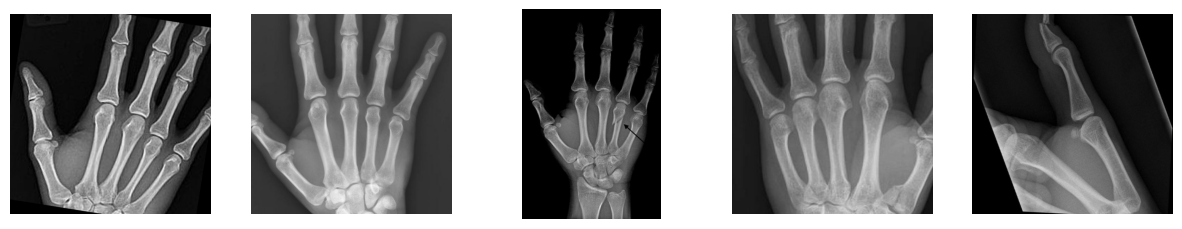

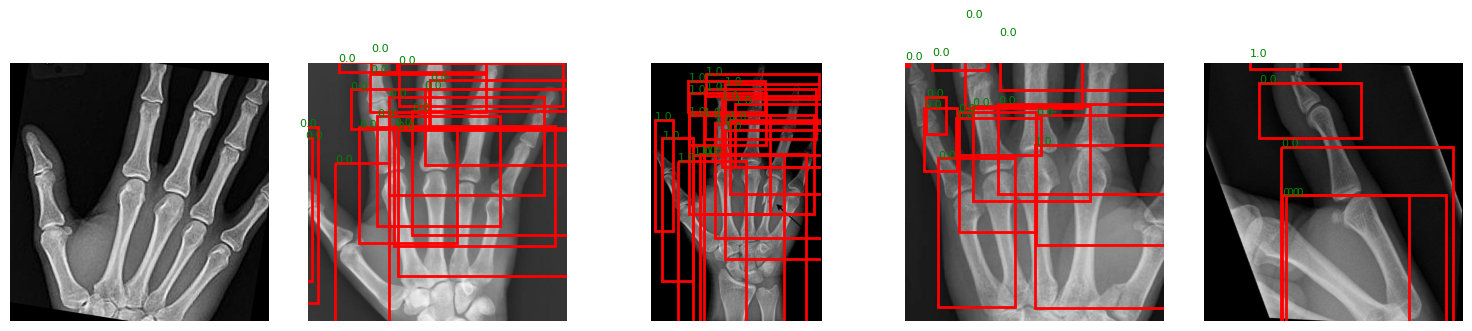

In [3]:
from matplotlib import patches
# Get the path of the extracted images
image_dir = "/content/data/train/images"

# Get the path of the label files
label_dir = "/content/data/train/labels"

# Get a list of all image file names
image_files = os.listdir(image_dir)

# Select 5 random images
random_images = random.sample(image_files, 5)

# Plot the random images without labels (row 1)
plt.figure(figsize=(15, 6))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(image_dir, image_name)

    image = plt.imread(image_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

# Plot the random images with labels (row 2)
plt.figure(figsize=(15, 6))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

    image = plt.imread(image_path)
    plt.subplot(2, 5, i+6)
    plt.imshow(image)
    plt.axis('off')

    # Read the label file and draw bounding boxes
    with open(label_path, 'r') as f:
        labels = f.readlines()
    for label in labels:
        parts = list(map(float, label.strip().split()))
        if len(parts) < 5:
            print(f"Skipping label with less than 5 parts: {label}")
            continue
        class_id, x, y, w, h = parts[:5]
        x1 = int((x - w/2) * image.shape[1])
        y1 = int((y - h/2) * image.shape[0])
        x2 = int((x + w/2) * image.shape[1])
        y2 = int((y + h/2) * image.shape[0])
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1, str(class_id), color='green', fontsize=8)

plt.tight_layout()
plt.show()


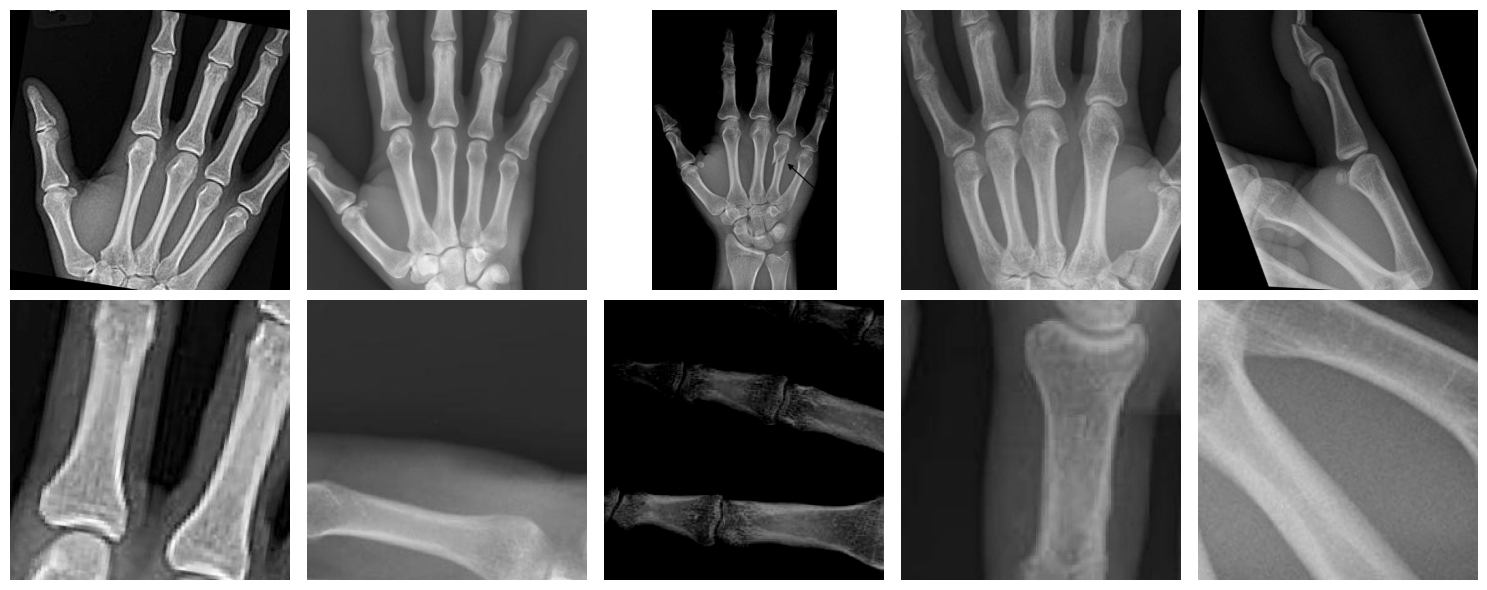

In [4]:
import albumentations as A

# Define the augmentation transforms
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2),
    A.RandomCrop(224,224)
])

# Plot the random images without labels and after segmentation
plt.figure(figsize=(15, 6))
for i, image_name in enumerate(random_images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace(".jpg", ".txt"))

    # Read the image
    image = plt.imread(image_path)

    # Apply augmentation transforms
    augmented = transform(image=image)
    augmented_image = augmented["image"]

    # Plot the original image without labels
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

    # Plot the augmented image after segmentation
    plt.subplot(2, 5, i+6)
    plt.imshow(augmented_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Zero Shot Learning
Zero-Shot Learning (ZSL) is particularly relevant to image segmentation, including medical image segmentation. In traditional segmentation models, the model is trained to recognize and segment specific classes or categories present in the training data. However, these models may struggle when encountering new classes not seen during training.

This is where ZSL comes into play. In the context of segmentation, Zero-Shot Segmentation models are trained in such a way that they can segment objects or classes they have never seen before during training. This is achieved by leveraging auxiliary information that associates observed and non-observed classes.

###  Loading and Using the YOLOv8 Segmentation Model with Zero-Shot Learning

In this section, we will load the YOLOv8 segmentation model, which is capable of Zero-Shot Learning (ZSL). We will use it to perform segmentation on an image, including classes that the model has not seen during training. Finally, we will visualize the segmentation results.

Using device: cuda

image 1/1 /content/data/train/images/0_jpg.rf.301f9bcfb4a4f2bbb68650892f14db3e.jpg: 640x640 1 person, 42.9ms
Speed: 6.7ms preprocess, 42.9ms inference, 2702.6ms postprocess per image at shape (1, 3, 640, 640)


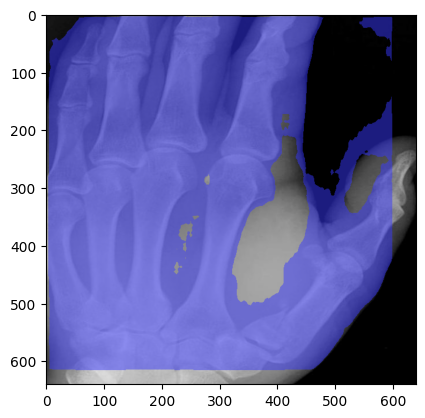

In [5]:
os.environ['WANDB_MODE'] = 'disabled'

# Check for CUDA device and set it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


# Load YOLOv8 segmentation model.nano
model = YOLO('yolov8n-seg.pt').to(device)

# Get the path of the image
image_path = "/content/data/train/images/0_jpg.rf.301f9bcfb4a4f2bbb68650892f14db3e.jpg"

# Perform segmentation on the image
results = model(image_path)

# Visualize the results
plt.imshow(results[0].plot(boxes=False))
plt.show()


### Exercise

Try doing zero shot segmentation for various YOLOv8 segmentation variants and note the differences i.e small, medium, large and extra large

In [14]:
#TO DO:


### Fine-Tuning the YOLOv8 Segmentation Model
In this section, we will fine-tune the YOLOv8 segmentation model. Fine-tuning involves training a pre-existing model (a process also known as transfer learning) on a new task. It leverages the learned feature representations of the original model, which can lead to significant improvements in performance, especially when the new task is similar to the original one.

In [6]:
# Load YOLOv8 segmentation model.nano
model = YOLO('yolov8n-seg.pt').to(device)
training = model.train(data='/content/data/data.yaml', epochs=50, imgsz=256, batch=8)

engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=256, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=

train: Scanning /content/data/train/labels... 592 images, 10 backgrounds, 0 corrupt: 100%|██████████| 592/592 [00:00<00:00, 1401.20it/s]

train: WARNING ⚠️ /content/data/train/images/112_jpg.rf.e55b6d48cbe88abded5d749855f194bd.jpg: 1 duplicate labels removed
train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/data/valid/labels... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<00:00, 392.27it/s]

val: New cache created: /content/data/valid/labels.cache


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/segment/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.623G      1.583      2.626      2.997      1.298        206        256: 100%|██████████| 74/74 [00:34<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all         52        436      0.391      0.418      0.319      0.214       0.39      0.415      0.311      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.537G      1.192      1.679       1.78      1.038        133        256: 100%|██████████| 74/74 [00:35<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all         52        436      0.361      0.724      0.394      0.262      0.351      0.697      0.372      0.212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.535G      1.045      1.541      1.523      1.006        111        256: 100%|██████████| 74/74 [00:24<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

                   all         52        436      0.409      0.743      0.429        0.3      0.398      0.719      0.402      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50     0.558G      0.996      1.445      1.429     0.9954         92        256: 100%|██████████| 74/74 [00:27<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.01it/s]

                   all         52        436       0.42      0.741      0.466      0.328      0.435      0.723      0.462      0.295



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50     0.558G      0.987      1.478      1.385     0.9941        146        256: 100%|██████████| 74/74 [00:26<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

                   all         52        436      0.432      0.743      0.508      0.365      0.435      0.736      0.497      0.322



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.537G      0.933      1.435      1.351     0.9729        118        256: 100%|██████████| 74/74 [00:27<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all         52        436      0.516      0.725      0.565      0.413      0.512      0.721      0.551       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.537G       0.95      1.402      1.319     0.9792        106        256: 100%|██████████| 74/74 [00:28<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

                   all         52        436      0.524      0.734      0.585      0.435      0.517      0.724      0.571       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.558G     0.9072      1.325      1.292     0.9674        145        256: 100%|██████████| 74/74 [00:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.02it/s]

                   all         52        436      0.496      0.667      0.533      0.395      0.496      0.668      0.525      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.602G     0.8839      1.276      1.279     0.9595        116        256: 100%|██████████| 74/74 [00:25<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

                   all         52        436      0.556       0.69      0.574       0.42      0.561      0.685      0.568      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.558G     0.8894      1.296      1.277     0.9653        120        256: 100%|██████████| 74/74 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]

                   all         52        436      0.566      0.728      0.611      0.452      0.561      0.717      0.596       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.654G     0.8646      1.237       1.25     0.9616        146        256: 100%|██████████| 74/74 [00:25<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]

                   all         52        436      0.533      0.721        0.6      0.443      0.531      0.698      0.579      0.391



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.535G     0.8544      1.241      1.215     0.9487        105        256: 100%|██████████| 74/74 [00:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]

                   all         52        436        0.6      0.736       0.65      0.483      0.598      0.733      0.645      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.537G     0.8572      1.234      1.209     0.9499        113        256: 100%|██████████| 74/74 [00:25<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

                   all         52        436      0.553      0.711      0.648       0.48      0.553      0.702      0.643      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.558G     0.8356      1.237      1.169     0.9457         89        256: 100%|██████████| 74/74 [00:25<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

                   all         52        436      0.581      0.767      0.614      0.477      0.581      0.758      0.605      0.402



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.579G     0.8218      1.164      1.163      0.938        122        256: 100%|██████████| 74/74 [00:27<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all         52        436       0.55      0.793      0.639        0.5       0.55      0.783      0.629      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.518G     0.8196      1.203      1.197      0.942         84        256: 100%|██████████| 74/74 [00:25<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all         52        436      0.529      0.734      0.612       0.47      0.551      0.681      0.604       0.38



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.535G     0.8147      1.148      1.182     0.9377        185        256: 100%|██████████| 74/74 [00:30<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         52        436      0.572      0.732       0.67      0.492      0.565      0.723      0.652      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.558G     0.7826      1.143      1.113     0.9264        124        256: 100%|██████████| 74/74 [00:26<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.77it/s]

                   all         52        436      0.576      0.754      0.591      0.457      0.568      0.745      0.581      0.385



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.535G     0.7842      1.145       1.13     0.9345        115        256: 100%|██████████| 74/74 [00:25<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

                   all         52        436      0.557      0.767       0.64      0.497      0.551      0.754      0.632      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.558G     0.7921      1.161      1.153     0.9299        119        256: 100%|██████████| 74/74 [00:27<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all         52        436      0.602      0.741       0.63      0.485      0.601      0.712      0.614      0.384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.535G      0.812       1.12       1.17     0.9378        133        256: 100%|██████████| 74/74 [00:25<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all         52        436      0.604      0.794      0.672       0.51      0.586      0.796      0.661      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.579G     0.7852      1.128      1.142     0.9284        104        256: 100%|██████████| 74/74 [00:26<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all         52        436      0.596      0.736      0.662      0.515      0.593      0.728      0.651      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.537G     0.7586      1.075      1.097     0.9179        156        256: 100%|██████████| 74/74 [00:25<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.96it/s]

                   all         52        436      0.603      0.738      0.631      0.489      0.595      0.723      0.618      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.535G     0.7903      1.122      1.113     0.9211        148        256: 100%|██████████| 74/74 [00:25<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]

                   all         52        436      0.645      0.787       0.69      0.538      0.658      0.777      0.685       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.65G     0.7503      1.084      1.085       0.92        237        256: 100%|██████████| 74/74 [00:28<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all         52        436       0.63      0.764      0.674      0.524      0.637      0.748      0.667      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.537G     0.7636      1.069      1.066     0.9211        209        256: 100%|██████████| 74/74 [00:24<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all         52        436      0.537      0.804       0.61       0.47      0.533      0.799        0.6      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.537G     0.7528      1.073      1.113     0.9207        137        256: 100%|██████████| 74/74 [00:29<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

                   all         52        436      0.562      0.691      0.587      0.459      0.556      0.679      0.578      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.554G     0.7581      1.089      1.092     0.9197        146        256: 100%|██████████| 74/74 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all         52        436      0.634      0.762      0.671      0.526      0.631      0.755      0.662      0.482



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.535G     0.7467      1.036      1.057     0.9137        144        256: 100%|██████████| 74/74 [00:25<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]

                   all         52        436      0.556      0.811      0.644        0.5      0.552      0.802      0.635      0.421



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.556G       0.74      1.045      1.063     0.9161         81        256: 100%|██████████| 74/74 [00:26<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all         52        436      0.528      0.732      0.618      0.492      0.539      0.725      0.612      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.516G     0.7215      1.021      1.049     0.9077         72        256: 100%|██████████| 74/74 [00:25<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all         52        436      0.538      0.807      0.671      0.535      0.565      0.741      0.659       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.558G     0.7246      1.017       1.05     0.9081        150        256: 100%|██████████| 74/74 [00:25<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

                   all         52        436      0.552      0.755      0.589       0.47      0.549      0.749      0.581      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.514G     0.7162      1.014      1.031     0.9089        107        256: 100%|██████████| 74/74 [00:28<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

                   all         52        436      0.538      0.807      0.647       0.52       0.55      0.763      0.642      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.535G     0.7118     0.9918      1.013     0.9031        143        256: 100%|██████████| 74/74 [00:25<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all         52        436      0.594      0.816      0.674      0.545      0.591      0.812      0.667      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.556G     0.7221      1.011      1.044     0.9094        129        256: 100%|██████████| 74/74 [00:27<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all         52        436      0.579      0.831       0.62        0.5      0.579      0.823      0.613      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.556G     0.7193      1.012      1.013     0.9098        109        256: 100%|██████████| 74/74 [00:26<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all         52        436       0.58      0.744      0.617      0.486      0.576      0.736      0.611      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.535G     0.7139     0.9864      1.013     0.9045        157        256: 100%|██████████| 74/74 [00:27<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all         52        436      0.558      0.801      0.597       0.47      0.555      0.793      0.588      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.558G     0.7097     0.9933     0.9931      0.906        135        256: 100%|██████████| 74/74 [00:27<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]

                   all         52        436      0.544      0.797      0.617      0.494      0.542      0.796      0.614      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.577G     0.7143     0.9922     0.9951     0.9125        127        256: 100%|██████████| 74/74 [00:25<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all         52        436      0.426      0.718      0.512      0.402      0.422      0.716      0.506      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.537G     0.6806     0.9494     0.9864     0.8971        104        256: 100%|██████████| 74/74 [00:24<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

                   all         52        436      0.522      0.785      0.608      0.487      0.519      0.787      0.605      0.431


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.512G     0.6577     0.9439     0.9878     0.8959         88        256: 100%|██████████| 74/74 [00:16<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

                   all         52        436      0.596      0.756       0.68      0.542      0.594      0.748      0.671      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.533G     0.6588     0.9252     0.9231     0.8874         82        256: 100%|██████████| 74/74 [00:15<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.93it/s]

                   all         52        436      0.485      0.641      0.535      0.406       0.48      0.629      0.524      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      43/50     0.512G     0.6445     0.9299     0.9481     0.8903         61        256: 100%|██████████| 74/74 [00:15<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

                   all         52        436      0.509      0.743      0.587       0.46      0.507      0.727      0.575      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      44/50     0.535G     0.6366     0.9144     0.9495     0.8901        121        256: 100%|██████████| 74/74 [00:15<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]

                   all         52        436      0.557      0.701      0.582      0.453      0.553      0.696      0.574      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      45/50     0.537G     0.6318     0.8717     0.9148     0.8805         40        256: 100%|██████████| 74/74 [00:13<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

                   all         52        436      0.555      0.818      0.634       0.51      0.551      0.814      0.628      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      46/50     0.535G     0.6145     0.8892     0.8592      0.876         58        256: 100%|██████████| 74/74 [00:12<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]

                   all         52        436      0.465      0.751      0.497       0.39      0.457      0.737      0.487      0.338



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      47/50     0.648G      0.625     0.8662     0.8483     0.8827         49        256: 100%|██████████| 74/74 [00:13<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

                   all         52        436      0.591      0.592      0.562      0.447      0.586      0.588      0.555      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      48/50     0.533G     0.6042     0.8493     0.8748      0.873         25        256: 100%|██████████| 74/74 [00:15<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all         52        436      0.497      0.678      0.532      0.425        0.5      0.666      0.522      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      49/50     0.512G     0.6025     0.8437     0.8404     0.8751         83        256: 100%|██████████| 74/74 [00:15<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

                   all         52        436      0.455      0.648        0.5      0.397      0.455      0.642      0.493      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      50/50     0.514G     0.5962     0.8382     0.8207     0.8705         85        256: 100%|██████████| 74/74 [00:15<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all         52        436      0.458      0.662      0.512      0.409      0.457      0.659      0.507      0.352



50 epochs completed in 0.365 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 6.7MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 6.7MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


                   all         52        436      0.595      0.754       0.68      0.542      0.593      0.749      0.671      0.472
                     -         52        206      0.554      0.777      0.667      0.555      0.555      0.777      0.665      0.493
seg-2-full- - v10 2023-11-20 2-59pm         52        230      0.637      0.732      0.693      0.529      0.631      0.722      0.677      0.452
Speed: 0.2ms preprocess, 8.9ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/segment/train3


### Image Inference
Now that we've trained our model, it's time to put it to the test! We'll select the best performing model and use it to run inference on a set of images.

Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning /content/data/valid/labels.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]


                   all         52        436      0.584      0.757      0.674      0.539      0.588       0.74      0.665      0.462
                     -         52        206      0.543      0.791      0.665      0.556      0.553       0.78      0.662      0.489
seg-2-full- - v10 2023-11-20 2-59pm         52        230      0.624      0.722      0.683      0.522      0.624      0.699      0.668      0.435
Speed: 0.6ms preprocess, 46.5ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/segment/train32

image 1/1 /content/multiple_fractures.jpg: 192x256 6 -s, 2 seg-2-full- - v10 2023-11-20 2-59pms, 231.7ms
Speed: 1.0ms preprocess, 231.7ms inference, 6.9ms postprocess per image at shape (1, 3, 192, 256)


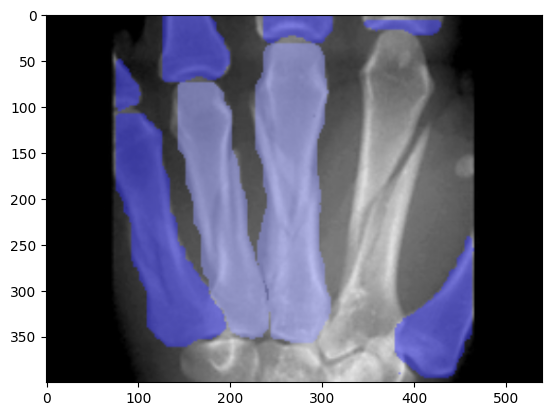

In [7]:
predict_results = model.val()
prediction = model('/content/multiple_fractures.jpg')

# Visualize the results
plt.imshow(prediction[0].plot(boxes=False))
plt.show()

                         epoch           train/box_loss  \
count                30.000000                30.000000   
mean                 15.500000                 1.631560   
std                   8.803408                 0.823663   
min                   1.000000                 1.013400   
25%                   8.250000                 1.126125   
50%                  15.500000                 1.332150   
75%                  22.750000                 1.707250   
max                  30.000000                 4.299300   

                train/seg_loss           train/cls_loss  \
count                30.000000                30.000000   
mean                  2.184650                 1.626520   
std                   0.958882                 0.698936   
min                   1.481800                 1.162900   
25%                   1.598625                 1.235225   
50%                   1.817000                 1.338050   
75%                   2.299500                 1.634250

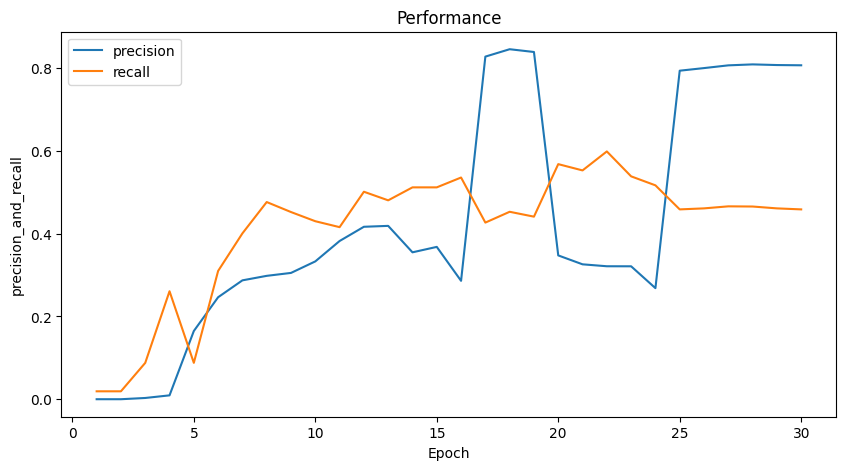

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your results file
df = pd.read_csv('/content/runs/segment/train/results.csv')

print(df.describe())

# Plotting the mAP value
plt.figure(figsize=(10, 5))

plt.plot(df['                  epoch'], df['   metrics/precision(M)'], label='precision')
plt.plot(df['                  epoch'], df['      metrics/recall(M)'], label='recall')


plt.xlabel('Epoch')
plt.ylabel('precision_and_recall')
plt.title('Performance')
plt.legend()
plt.show()

In [9]:
df.columns


Index(['                  epoch', '         train/box_loss',
       '         train/seg_loss', '         train/cls_loss',
       '         train/dfl_loss', '   metrics/precision(B)',
       '      metrics/recall(B)', '       metrics/mAP50(B)',
       '    metrics/mAP50-95(B)', '   metrics/precision(M)',
       '      metrics/recall(M)', '       metrics/mAP50(M)',
       '    metrics/mAP50-95(M)', '           val/box_loss',
       '           val/seg_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')

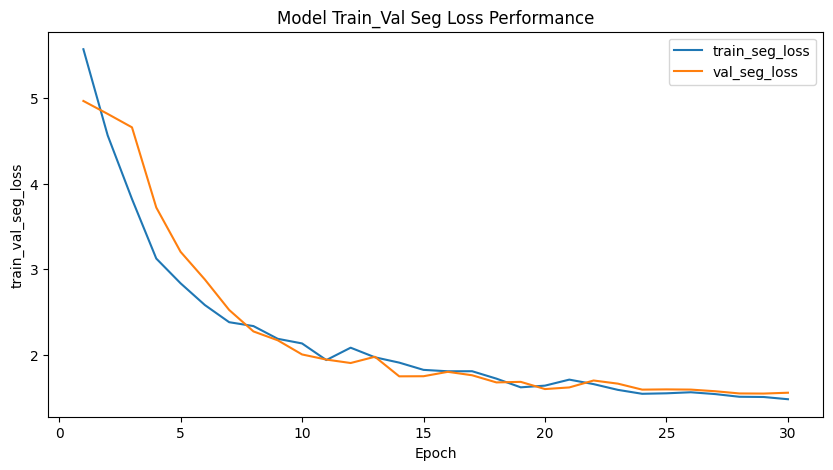

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df['                  epoch'], df['         train/seg_loss'], label='train_seg_loss')
plt.plot(df['                  epoch'], df['           val/seg_loss'], label='val_seg_loss')
plt.xlabel('Epoch')
plt.ylabel('train_val_seg_loss')
plt.title('Model Train_Val Seg Loss Performance')
plt.legend()
plt.show()

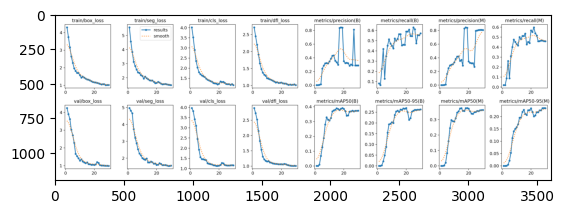

In [11]:
plt.imshow(plt.imread("/content/runs/segment/train/results.png"))

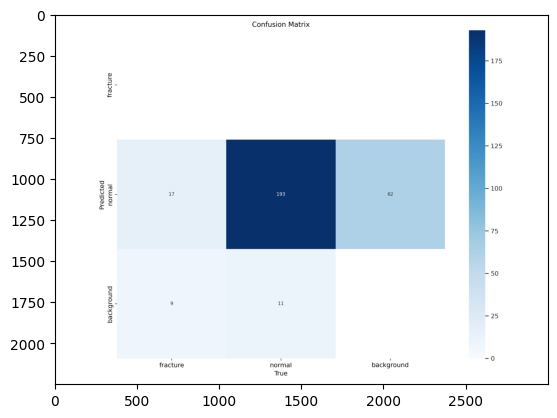

In [12]:
plt.imshow(plt.imread("/content/runs/segment/train/confusion_matrix.png"))

# Exercise: Exploring YOLOv8 Segmentation Variants

In this exercise, you will experiment with different YOLOv8 segmentation variants, batch sizes, and epochs to observe their effects on the segmentation results.

1. **Segmentation Variants**: Try using different YOLOv8 segmentation variants such as 'yolov8s-seg', 'yolov8m-seg', 'yolov8l-seg', and 'yolov8x-seg'. Observe how the size and complexity of the model affect the segmentation results and computation time.

2. **Batch Sizes**: Experiment with different batch sizes. Start with a small batch size (e.g., 2 or 4), and gradually increase it (e.g., 8, 16, 32). Note how the batch size impacts the training speed and memory usage.

3. **Epochs**: Vary the number of epochs for training. Begin with a small number of epochs (e.g., 5 or 10) and gradually increase it (e.g., 20, 50, 100). Observe how the number of epochs affects the model's performance and overfitting.

Remember to record your observations and findings. This will help you understand the trade-offs involved and make informed decisions when fine-tuning models for your specific tasks. Happy experimenting!


In [13]:
#To do.

In [14]:
import glob
import os

# Plot and visualize images in a 2x2 grid.
def visualize(result_dir):
    """
    Function accepts a list of images and plots
    them in either a 1x1 grid or 2x2 grid.
    """
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    if len(image_names) < 4:
        plt.figure(figsize=(10, 7))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(1, 1, i+1)
            plt.imshow(image)
            plt.axis('off')
            break
    if len(image_names) >= 4:
        plt.figure(figsize=(15, 12))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(2, 2, i+1)
            plt.imshow(image)
            plt.axis('off')
            if i == 3:
                break
    plt.tight_layout()
    plt.show()

This command is used to run the YOLOv8 model for inference on a set of images, using the best weights obtained from training. It specifies the model weights, the source of the images, the name for this run, and whether to overwrite existing files. It also ensures the results are saved for further analysis. This is a crucial step in evaluating the performance of the trained model.

In [15]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!yolo predict \
model='/content/runs/segment/train/weights/best.pt' \
source='/content/multiple_fractures.jpg' \
name='yolov8s_predict' \
exist_ok=True \
save=True
boxes=False

Ultralytics YOLOv8.2.15 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258454 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 /content/multiple_fractures.jpg: 192x256 7 normals, 118.5ms
Speed: 1.2ms preprocess, 118.5ms inference, 1966.3ms postprocess per image at shape (1, 3, 192, 256)
Results saved to runs/segment/yolov8s_predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


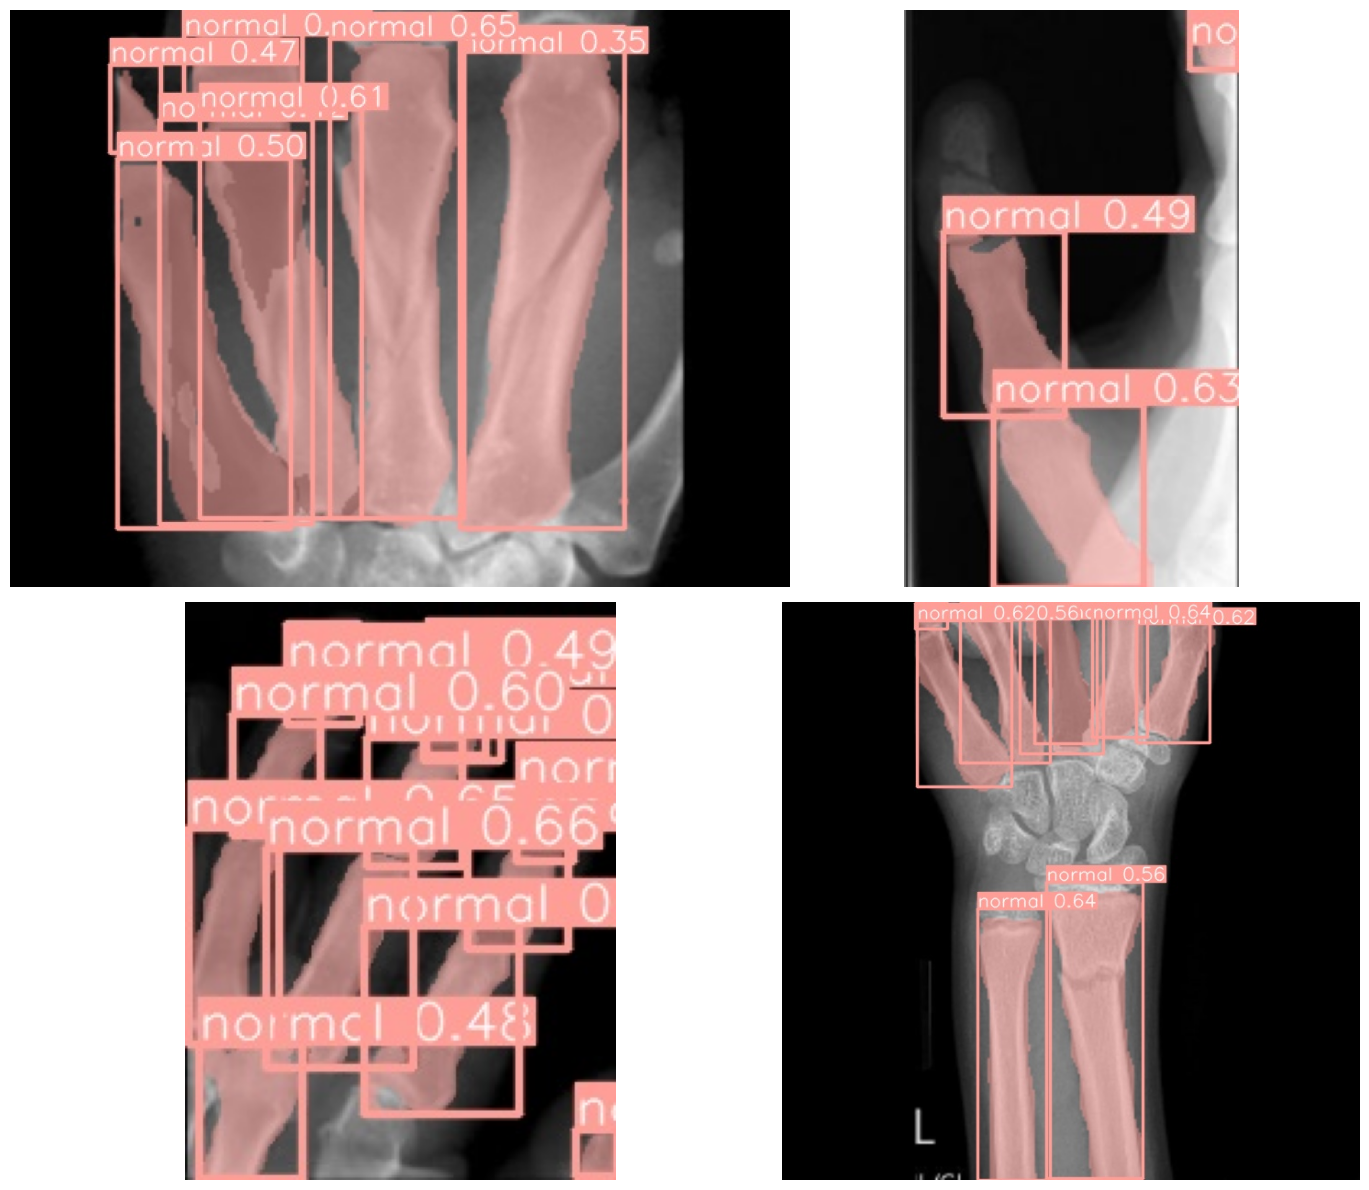

In [16]:
# visualize the segmentation results obtained from the inference run
visualize('/content/runs/segment/yolov8s_predict')